# NUMAR Landscape Model



Original paper: Chen, Ronghua & Twilley, Robert. (1999). A Simulation Model of Organic Matter and Nutrient Accumulation in Mangrove Wetland Soils. Biogeochemistry. 44. 93-118. 10.1007/BF00993000. https://www.researchgate.net/publication/226714484_A_Simulation_Model_of_Organic_Matter_and_Nutrient_Accumulation_in_Mangrove_Wetland_Soils
- Python Conversion: Tom Kaiser, Louisiana State University
- Python Wrapper and Notebook: Alex Christensen Jet Propulsion Laboratory, California Institute of Technology.
- Model Updates For Marsh: Andy Cassaway and Pradipta Biswas, Louisiana State University

This notebook was created at the JJet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004).





In [9]:
import os
import sys

# For Google Colab Only:

In [10]:
%%capture
!pip install rasterio
!pip install cartopy
!apt install gdal-bin


# For Google Colab Only:

In [11]:
if os.path.isdir('/content/deltax_workshop_2024'):
  !rm -r /content/deltax_workshop_2024
! git clone https://github.com/ornldaac/deltax_workshop_2024.git

%cd /content/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example
sys.path.append('/content/deltax_workshop_2024/tutorials/6_NUMARModel/src')


Cloning into 'deltax_workshop_2024'...
remote: Enumerating objects: 567, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 567 (delta 117), reused 203 (delta 93), pack-reused 307
Receiving objects: 100% (567/567), 119.63 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (222/222), done.
Updating files: 100% (131/131), done.
[Errno 2] No such file or directory: '/content/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example'
/Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example


# 1a. Import Python Packages

In [12]:
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
from  matplotlib.colors import ListedColormap, BoundaryNorm
from  matplotlib.cm import ScalarMappable
import math
import pandas as pd
import cartopy.crs as ccrs
import imageio
from osgeo import gdal, ogr
import numpy as np

# import earthaccess
# earthaccess.login()



# 1b. Set working directories

In [13]:
example_dir = Path(os.getcwd())
repo_dir = example_dir.parent.absolute()
script_dir = repo_dir / 'src'
tmp_dir = example_dir / 'TMP'

Path(tmp_dir).mkdir(parents=True, exist_ok=True)
sys.path.insert(1,str(script_dir))


# 1c. Import NUMAR model





In [14]:
from landscape import run_numar
from input_files import *

# 2. Define AOI using a geojson file





In [15]:
Path(tmp_dir).mkdir(parents=True, exist_ok=True)
ref_file = example_dir / 'aoi_4326.geojson'
res = 100
AOI = gpd.read_file(ref_file)
bounds_4326 =  AOI.total_bounds

x1,y1,x2,y2 = math.floor(bounds_4326[0]),math.floor(bounds_4326[3]),math.floor(bounds_4326[2]),math.floor(bounds_4326[1])

zone = int(np.ceil((bounds_4326[0] + 180)/6))

if y1>=0 and y2>=0:
    NS = 'n'
    EPSG = 32200+zone
elif y1>=0 and y2<0:
    NS = 'n'
    NS2 = 's'
    EPSG = 32200+zone
else:
    NS = 's'
    y = abs(y1)
    EPSG = 32700+zone
if x1>=0:
    EW = 'e'
elif x1<0 and x2>=0:
    EW = 'e'
    EW2 = 'w'
else:
    EW = 'w'
    x = abs(x1)
print('UTM Zone: %s%s EPSG: %s' %(zone,NS,EPSG))

AOI_utm = AOI.to_crs(EPSG)
AOI_utm.to_file(tmp_dir / ('aoi_%s.shp' %(EPSG)))
os.system("gdal_rasterize -burn 0 -tr %s %s %s %s" %(res,res,tmp_dir/('aoi_%s.shp'%(EPSG)),tmp_dir / ('aoi_%s.tif'%(EPSG))))



UTM Zone: 15n EPSG: 32215
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [16]:
ref_file = tmp_dir / ('aoi_%s.tif' %(EPSG))
AOI = rasterio.open(ref_file)

profile = AOI.profile


# 3. Get Input Rasters

### You need to download the following files:
- ### Delta-X AVIRIS-NG Aboveground Biomass (spring and Fall)
    - ### https://doi.org/10.3334/ORNLDAAC/2138
- ### ESA WorldCover 2021 Landcover Maps
    - ### https://worldcover2021.esa.int/downloader
- ### CPRA Vegetation
    - ### https://cims.coastal.la.gov/Viewer/GISDownload.aspx
    - ### direct download = https://cims.coastal.louisiana.gov/Viewer/metadata/zips/vegtype2021.zip
- ### Delta-X Delft3D Annual inorganic mass accumulation rate (IMAR): annual rates of mineral mass deposited on wetlands, estimated from analysis of storm frequency and deposition.:
    - ### https://doi.org/10.3334/ORNLDAAC/2301
    - ### https://doi.org/10.3334/ORNLDAAC/2302

In [17]:
AGB, SALINITY, LANDCOVER, IMAR, BASINS, CLASSES, mask, lats,lons = get_input_files(AOI,example_dir,example_dir,tmp_dir,EPSG,bounds_4326)



##### ABOVEGROUND BIOMASS



##### ESA WorldCover landcover type



##### CPRA Vegetation Type (with Salinity Zones)


##### Modified Hydrologic Basins


##### Delft3D Inorganice Mass Accumulation Rate (IMAR)


##### Delta-X Watermask


# 4. Define Input Parameters at each pixel

### From Delft3D Model IMAR output:
- si = inorganic matter deposition rate on the soil surface (g/cm2/yr)
- oms = organic matter deposition rate on the soil surfcae (g/cm2/yr)

### From AVIRIS-NG Biomass data products:
- r0 = root biomass at the surface (g/cm2)

### Based on landcover type:
- b0 = self-packing density of organic matter (g/cm3)
- bi = self-packing density of inorganic matter (g/cm3)
- c0 = lignin content in the surface deposit (g/g)
- c1 = ash content in the root biomass (g/g)
- c2 = cellulose content in the surface deposit (g/g)
- c4 = cellulose content in the root biomass(g/g)
- fc1 = lignin content in the root biomass
- kb = belowground decomposition rate of labile organic matter (1/yr)
- kc = cellulos decomposition rate (1/yr)
- kl = lignin decomposition rate (1/yr)
- kr = root turnover rate (1/yr)
- e = root attenuation rate

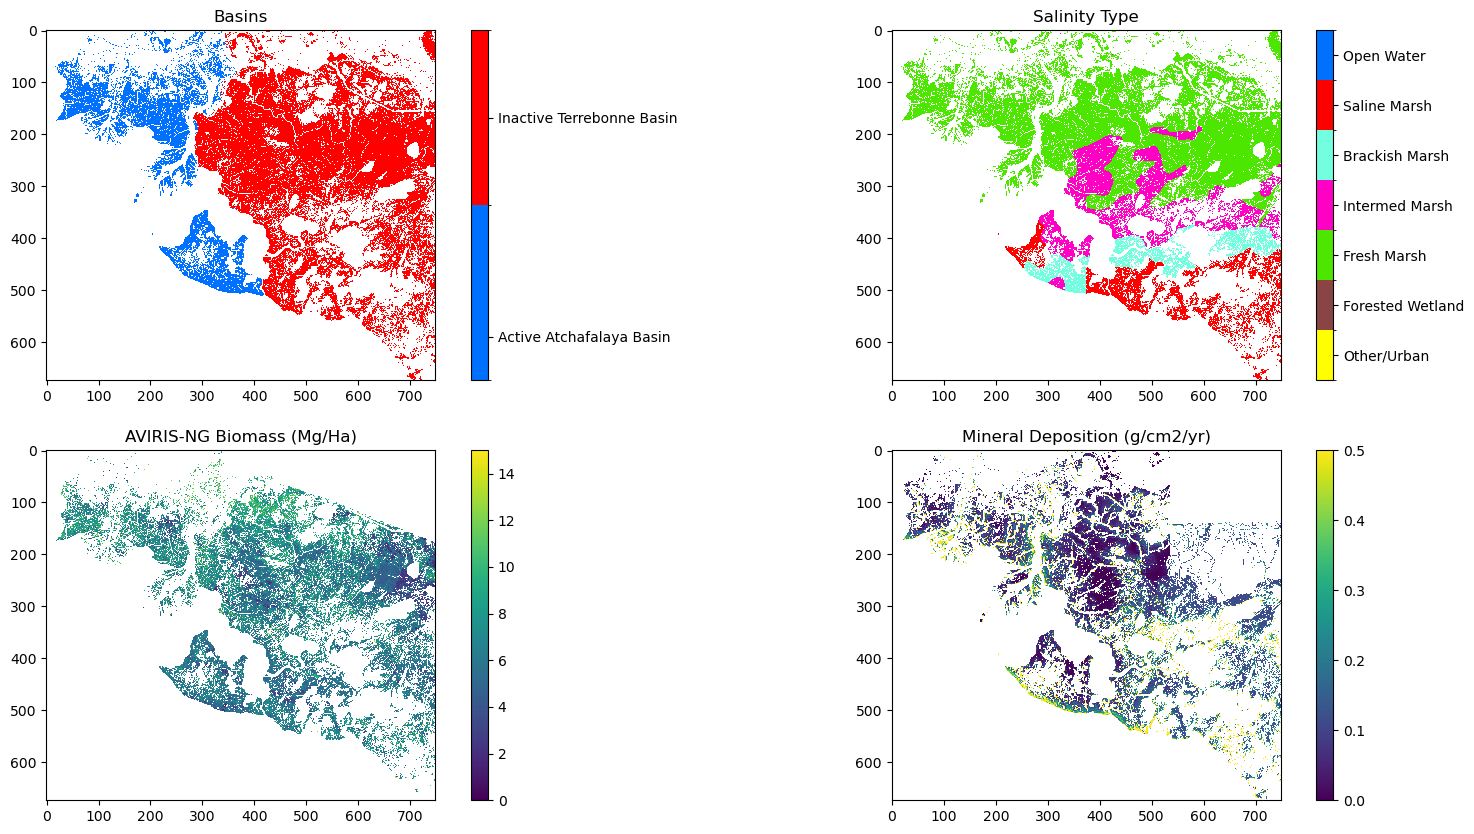

In [18]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize = (20,10))

colors = ['#0070ff','#ff0000']
values = [0,2]
labels = ['Active Atchafalaya Basin','Inactive Terrebonne Basin']
ticks = [0.5,2.5]
bounds = np.append(values,values[-1] + 1)
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))
im1 = ax1.imshow(BASINS*mask,cmap=cmap,norm=norm,interpolation='nearest')
ax1.set_title('Basins')
cbar = fig.colorbar(im1,ax=ax1,ticks=ticks)
cbar.ax.set_yticklabels(labels)

# colors = ['#00a000','#966400','#ffb400','#ffff64','#c31400','#fff5d7','#ffffff','#0046c8','#00dc82','#009678','#ffebaf']
# values = [10,20,30,40,50,60,70,80,90,95,100]
# labels = ["Tree cover","Shrubland","Grassland","Cropland","Built-up","Bare / sparse vegetation","Snow and ice","Permanent water bodies","Herbaceous wetland","Mangroves","Moss and lichen"]
# bounds = np.append(values, values[-1] + 2)
# ticks = [15,25,35,45,55,65,75,85,93,97,101]
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(bounds, ncolors=len(colors))
# im2 = ax2.imshow(LANDCOVER*mask,cmap=cmap,norm=norm,interpolation='nearest')
# ax2.set_title('WorldCover 2021')
# cbar = fig.colorbar(im2,ax=ax2,ticks = ticks)
# cbar.ax.set_yticklabels(labels)  # horizontal colorbar


colors = ['#ffff00','#894444','#4ce600','#ff00c5','#73ffdf','#ff0000','#0070ff']
values =[1,2,3,4,5,6,7]
labels = ['Other/Urban','Forested Wetland','Fresh Marsh','Intermed Marsh','Brackish Marsh','Saline Marsh','Open Water']
bounds = np.append(values, values[-1] + 1)
ticks = [1.5,2.5,3.5,4.5,5.5,6.5,7.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))
im2 = ax2.imshow(SALINITY*mask,cmap=cmap,norm=norm,interpolation='nearest')
cbar = fig.colorbar(im2,ax=ax2,ticks = ticks)
cbar.ax.set_yticklabels(labels)  # horizontal colorbar
ax2.set_title('Salinity Type')

im3 = ax3.imshow(AGB*mask,vmin=0,vmax=15,interpolation='nearest')
ax3.set_title('AVIRIS-NG Biomass (Mg/Ha)')
fig.colorbar(im3,ax = ax3)


im4 = ax4.imshow(IMAR*mask,vmin=0,vmax=.5,interpolation='nearest')
ax4.set_title('Mineral Deposition (g/cm2/yr)')
fig.colorbar(im4,ax = ax4)


In [19]:
run_config = pd.DataFrame({
                    'lat':lats.flatten(),
                    'long':lons.flatten()
                        })

In [20]:
parameters_df = pd.read_csv(script_dir/'parameters_by_class.csv')
parameters = parameters_df.columns


In [21]:
for parameter in parameters[2:14]:
    print(parameter)
    lut = parameters_df[parameter].values
    classes2 = np.where(np.isnan(CLASSES),0,CLASSES).astype(int)
    output = lut[classes2]*mask
    run_config[parameter] = output.flatten()

b0
bi
c0
c1
c2
c4
fc1
kb
kc
kl
kr
e


In [22]:
oms = calculate_organicmatter_loading(IMAR,classes2,mask,parameters_df['omssi'].values)
run_config['oms'] = oms.flatten()
run_config['si'] = IMAR.flatten()

r0 = calculate_belowground_biomass(AGB,mask,classes2,parameters_df['e'].values,parameters_df['bgbagb'].values)
run_config['r0'] = r0.flatten()

#########################
[[oms ==> ORGANIC MASS ACCUMULATION RATE]]
Units = g/cm2/yr
#########################

#########################
[[r0 ==> BELOWGROUND BIOMASS]]
BGB:AGB = 0.35 fresh marsh, 0.62 brackish marsh, and 1.26 saline marsh
BGB at surface (r0) = (r50 * e)/(1-exp(-e*50))
Attenuation rate (e) = 0.03 fresh marsh, 0.05 brackish marsh, and 0.0406 saline marsh
Units = g/cm2
#########################



In [23]:
run_config = run_config.dropna().reset_index()
run_config['id'] = run_config.index

print('There are %s pixels' %(len(run_config)))

There are 77514 pixels


In [24]:
run_config[:].to_csv(example_dir/('NUMAR_Landscape_Input_%s.csv'%(res)))

# 5. Run NUMAR model for 100 years

The next cell will run the model. We are running at a reduced resolution (100m) to allow faster computation time. In Google Colab, this will take 15 minutes.

In [25]:
year100 = run_numar(example_dir/('NUMAR_Landscape_Input_%s.csv' %(res)),example_dir/('NUMAR_Landscape_Results_%s.csv' %(res)))

Constructed input file path: /Users/alchrist/Documents/GitHub/deltax_workshop_2024/tutorials/6_NUMARModel/Landscape_example/NUMAR_Landscape_Input_100.csv
There are 77514 pixels
calc for site_id 0.0 completed 0.0%
calc for site_id 10000.0 completed 12.9%
calc for site_id 20000.0 completed 25.8%
calc for site_id 30000.0 completed 38.7%
calc for site_id 40000.0 completed 51.6%
calc for site_id 50000.0 completed 64.5%
calc for site_id 60000.0 completed 77.4%
calc for site_id 70000.0 completed 90.3%


In [26]:
year100

,site_id,lat,long,Age_yr,Total Accretion 10yrs (cm),Total Accretion 20yrs (cm),Total Accretion 30yrs (cm),Total Accretion 40yrs (cm),Total Accretion 50yrs (cm),Total Accretion 60yrs (cm),...,Mean OM%,Mean OM Concentration (mg/cm3),Mean BD (g/cm3),C_Seq (g/m2/yr),OC Concentration (mg/cm3),IM(%),IM Concentration (mg/cc),Necromass (Mg/ha),Root Necromass (Mg/ha),Root Necromass Projected Up to 50 cm (Mg/ha)
0,0.0,3.284570e+06,672407.974939,99,1.361749,2.701429,4.013709,5.299467,6.559565,7.794844,...,5.118525,47.329340,0.929266,15.987990,12.671572,94.881475,881.936619,59.098990,0.976618,6.325407
1,1.0,3.284570e+06,673407.974939,99,5.508443,10.926712,16.233159,21.431261,26.524444,31.516076,...,5.109811,47.288831,0.930174,64.501229,12.646815,94.890189,882.885016,238.673898,3.532541,3.466742
2,2.0,3.284170e+06,656907.974939,99,1.805447,3.580983,5.319614,7.022559,8.691008,10.326124,...,5.104340,47.264531,0.930718,21.108486,12.631949,94.895660,883.453916,78.159499,1.071929,5.015989
3,3.0,3.284070e+06,673507.974939,99,1.300751,2.581250,3.836305,5.066680,6.273130,7.456400,...,5.143279,47.441731,0.926747,15.383339,12.740294,94.856721,879.305368,56.696572,1.212582,8.241294
4,4.0,3.283570e+06,647807.974939,99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,77509.0,3.219070e+06,711207.974939,99,3.264281,5.058626,6.939459,8.912716,10.967193,13.091083,...,5.744947,36.679114,0.709620,26.921086,9.929549,94.255053,672.940528,80.264926,40.422845,113.795758
77510,77510.0,3.219070e+06,711307.974939,99,3.297583,4.935120,6.575967,8.232214,9.899564,11.573912,...,4.436282,31.512577,0.889971,19.429032,6.267370,95.563719,858.458540,57.358292,15.236045,56.802268
77511,77511.0,3.218970e+06,711107.974939,99,3.027666,4.706254,6.473925,8.336720,10.284543,12.306485,...,5.919175,37.159737,0.692842,25.973625,10.272441,94.080825,655.682505,77.099646,40.278895,120.308320
77512,77512.0,3.218970e+06,711207.974939,99,3.294397,5.141646,7.095309,9.160462,11.324392,13.573366,...,6.070102,37.564507,0.678713,29.135949,10.561395,93.929898,641.148168,86.232689,46.390607,122.145362


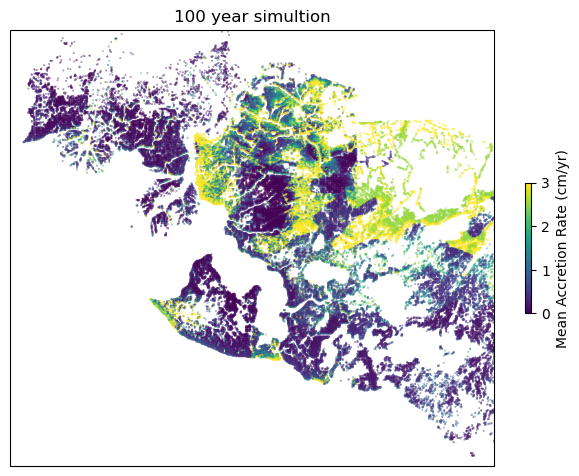

In [27]:

fig, ax= plt.subplots(1,1, subplot_kw={'projection': ccrs.epsg(EPSG)})
sc = ax.scatter(year100['long'],year100['lat'],s=0.05,vmin=0,vmax=3, c=year100['Mean Accretion (cm/yr)'])
plt.colorbar(sc,label='Mean Accretion Rate (cm/yr)',shrink=0.3)
plt.title('100 year simultion')
ax.set_extent([AOI.bounds.left,AOI.bounds.right,AOI.bounds.bottom,AOI.bounds.top], crs=ccrs.epsg(EPSG))
fig.tight_layout()
fig.savefig(example_dir/('MeanAccretion_100yr.png'))

In [28]:
os.system('rm -r %s' %(tmp_dir))

0